In [227]:
import pandas as pd
import shap
from pprint import pprint
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from scipy.stats import kendalltau
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score, precision_score, f1_score
from pyensembl import EnsemblRelease

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# save label encoder to global scope
le = LabelEncoder()
NUMBER_OF_BOOTSTRAPS = 5

In [1]:
ensemble_data = EnsemblRelease(99)
ensemble_data.download()
ensemble_data.index()

In [279]:
def creating_eugen_species_set():
    species = pd.read_csv('./../data/input/species.tsv', sep='\t', index_col=None, dtype=None)
    species_from_eugene = pd.read_csv('./../data/input/species_selected.csv', index_col=None, dtype=None)
    species = species[species['species'].isin(species_from_eugene['species'].values)]
    species.to_csv('./../data/input/species_eugene.tsv', sep='\t', index=None)
    
creating_eugen_species_set()

In [278]:
def create_list_for_rodrigo():
    gene_list = ['ENSG00000166669',
        'ENSG00000089234',
        'ENSG00000198663',
        'ENSG00000118298',
        'ENSG00000204536',
        'ENSG00000170835']
    csv_file = pd.read_csv('cross_species_df_merged.csv')
    cols_to_delete = []
    for column in list(csv_file.columns):
        if ('ENSG' in column or 'LRG' in column) and column not in cols:
            cols_to_delete.append(column)
        else:
            print(column)

    csv_file_1 = csv_file.drop(cols_to_delete, axis=1) 
    #csv_file = csv_file.dropna(axis=0, thresh=int(len(csv_file.columns)*0.9))
    csv_file_1 = csv_file_1[(~pd.isnull(csv_file_1['max_lifespan']))] # select only row where target is set
    #csv_file = csv_file.dropna(axis=1, thresh=int(len(csv_file)*0.9)) # remove all genes where percentage of NaN > 10%
    csv_file_1 = csv_file_1[csv_file_1['tissue'].isin(['Lung', 'Liver', 'Kidney', 'Brain', 'Heart'])] # remove underrepresented tissues
    
    csv_file_1.to_csv('selected_genes_dataframe_v2.csv', index=False)

In [270]:
def merge_datasets():
    expressions = pd.read_csv('./../data/input/expressions/by_animal_class/Mammalia.tsv', sep='\t')
    samples = pd.read_csv('./../data/input/samples_eugene.tsv', sep="\t", index_col=None, dtype=None)
    species = pd.read_csv('./../data/input/species_eugene.tsv', sep='\t', index_col=None, dtype=None)

    samples = samples.set_index('run')
    species = species.set_index('species')
    expressions_T = expressions.T
    expressions_T = expressions_T.rename(columns=expressions_T.iloc[0]).drop(expressions_T.index[0])
    expressions_T.to_csv('transposed_expressions.csv')
    joined_samples_expressions = expressions_T.join([samples], how='inner')
    cross_species_joined_df = joined_samples_expressions.merge(species, left_on='species', right_on=species.index)
    #for i, column in enumerate(cross_species_joined_df.columns):
        # put NaNs for columns with ; inside numeric values
     #   if 'ENSG' in column: 
     #       cross_species_joined_df[column] = pd.to_numeric(cross_species_joined_df[column], errors='coerce')
    print('Number of samples', len(cross_species_joined_df))
    cross_species_joined_df.to_csv('cross_species_df_merged.csv', index=False)
    
merge_datasets()


Number of samples 411


In [251]:
def add_metrics(current_metrics, model, ground_truth_X, ground_truth_Y):
    predictions = model.predict(ground_truth_X, num_iteration=model.best_iteration)
    test_y = ground_truth_Y
    fold_metrics = calculate_metrics(test_y, predictions)
    return np.add(current_metrics, np.array(list(fold_metrics.values())))

def regression_model_lightgbm(X_train, X_test, y_train, y_test, categorical):
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[categorical])
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    evals_result = {}

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'max_leaves': 20,
        'max_depth': 3,
        'learning_rate': 0.07,
        'feature_fraction': 0.8,
        'bagging_fraction': 1,
        'min_data_in_leaf': 6,
        'lambda_l1': 0.9,
        'lambda_l2': 0.9,
        "verbose": -1
    }

    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=500,
        valid_sets=lgb_eval,
        evals_result=evals_result,
        verbose_eval=1000,
        early_stopping_rounds=7)
    
    return gbm

def regression_for_interaction(X_train, y_train, categorical):
    if categorical:
        lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=[categorical])
    else:
        lgb_train = lgb.Dataset(X_train, y_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'max_leaves': 20,
        'max_depth': 3,
        'learning_rate': 0.07,
        'feature_fraction': 0.8,
        'bagging_fraction': 1,
        'min_data_in_leaf': 6,
        'lambda_l1': 0.9,
        'lambda_l2': 0.9,
    }

    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=30)
    
    return gbm

In [252]:
def sorted_stratification(X, Y, k):
    X['target'] = Y
    X = X.sort_values(by=['target'])
    partition_indexes = [[] for i in range(k)]
    i = 0
    index_of_sample = 0
   
    while i < (int(len(Y)/k)): 
        for j in range(k):
            partition_indexes[j].append((i*k)+j)
            index_of_sample = (i*k)+j
        i+=1

    index_of_sample += 1
    i = 0
    while index_of_sample < len(Y):
        partition_indexes[i].append(index_of_sample)
        index_of_sample += 1
        i+=1
        
    X_features = X.drop(['target'], axis=1)
    Y = X['target'].values
    X = X.drop(['target'], axis=1)    
        
    partition_Xs = []
    partition_Ys = []
    for pindex in partition_indexes:
        partition_Xs.append(X_features.iloc[pindex])
        partition_Ys.append(Y[pindex])
       
    return X, Y, partition_Xs, partition_Ys

In [253]:
def calculate_stable_shap_values(X, Y, index_of_categorical, label_to_predict):
    weight_of_features = []
    shap_values_out_of_fold = [[0 for i in range(len(X.values[0]))] for z in range(len(X))]
    #interaction_values_out_of_fold = [[[0 for i in range(len(X.values[0]))] for i in range(len(X.values[0]))] for z in range(len(X))]
    out_of_folds_metrics = [0, 0, 0]
    
    X, Y, partitions_of_X, partitions_of_Y = sorted_stratification(X, Y, NUMBER_OF_BOOTSTRAPS)
    
    
    for i in range(NUMBER_OF_BOOTSTRAPS):
        X_test = partitions_of_X[i]
        y_test = partitions_of_Y[i]

        X_train = pd.concat(partitions_of_X[:i] + partitions_of_X[i+1:])
        y_train = np.concatenate(partitions_of_Y[:i] + partitions_of_Y[i+1:], axis=0)
    
        # get trained model and record accuracy metrics
        model = regression_model_lightgbm(X_train, X_test, y_train, y_test, index_of_categorical)
        out_of_folds_metrics = add_metrics(out_of_folds_metrics, model, X_test, y_test)

        weight_of_features.append(model.feature_importance(importance_type='gain'))
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        #interaction_values = explainer.shap_interaction_values(X)
        shap_values_out_of_fold = np.add(shap_values_out_of_fold, shap_values)
        #interaction_values_out_of_fold = np.add(interaction_values_out_of_fold, interaction_values)
        
    # print average metrics results
    print('Accuracy of predicting ' + label_to_predict, np.divide(out_of_folds_metrics, NUMBER_OF_BOOTSTRAPS))
    
     # calculate shap values out of fold
    shap_values_out_of_fold = shap_values_out_of_fold / NUMBER_OF_BOOTSTRAPS
    shap_values_transposed = shap_values_out_of_fold.T
    X_transposed = X.T.values
        
    # get features that have stable weight across bootstraps
    output_features_by_weight = []
    for i, index_of_col in enumerate(weight_of_features[0]):
        cols = []
        for sample in weight_of_features:
            cols.append(sample[i])
        non_zero_cols = 0
        for col in cols:
            if col != 0:
                non_zero_cols += 1
        if non_zero_cols == NUMBER_OF_BOOTSTRAPS:
            if 'ENSG' in X.columns[i]:
                output_features_by_weight.append({
                    'ids': X.columns[i],
                    'gain_score_to_'+label_to_predict: np.mean(cols),
                    'name': ensemble_data.gene_name_of_gene_id(X.columns[i]),
                    'kendall_tau_to_'+label_to_predict: kendalltau(shap_values_transposed[i], X_transposed[i], nan_policy='omit')[0]
                })
    
    #output_features_by_weight = sorted(output_features_by_weight, key=lambda k: k['score'], reverse=True) 
        
    return {'list_of_weighted_features': output_features_by_weight,
            'stable_shap_values': shap_values_out_of_fold}


In [254]:
def plot_shap_values(shap_values, X):
    shap_feature_names = []
    X_display = X.copy()
    X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
    for col in X.columns:
        if 'ENSG' in col:
            shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
        else:
            shap_feature_names.append(col)
            
    shap.summary_plot(shap_values, X, feature_names=shap_feature_names)
    shap.dependence_plot("VARS2", shap_values, X, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)


In [271]:
def calculate_metrics(prediction, ground_truth):
     return {
            'R2': r2_score(ground_truth, prediction),
            'MSE': mean_squared_error(ground_truth, prediction),
            'MAE': mean_absolute_error(ground_truth, prediction),
     }
    
def encode_tissues(dataframe):
    le.fit(dataframe['tissue'].values)
    tissues_encoded = le.transform(dataframe['tissue'].values)
    dataframe['tissue_encoded'] = tissues_encoded
    
    return dataframe
    
    
def split_to_X_and_Y(dataframe, label_to_predict):
    if 'tissue' in dataframe.columns:
        X = dataframe.drop([label_to_predict, 'tissue'], axis=1)
        Y = dataframe[label_to_predict].values
        index_of_categorical_feature = list(X.columns).index('tissue_encoded')
    else:
        X = dataframe.drop([label_to_predict], axis=1)
        Y = dataframe[label_to_predict].values
        index_of_categorical_feature = None

    return X, X.values, Y, index_of_categorical_feature
    
    
def get_predictions(label_to_predict, ids=None):
    species_data = pd.read_csv('cross_species_df_merged.csv', low_memory=False)
    
    # remove other features (redundant and those that correlate with target)
    cols_to_delete = []
    for column in list(species_data.columns):
        if ids:
            if column not in ids and column not in ['tissue', label_to_predict]:
                cols_to_delete.append(column)
        else:
            if 'ENSG' not in column and column not in ['tissue', label_to_predict]:
                cols_to_delete.append(column)    
            
    species_data = species_data.drop(cols_to_delete, axis=1) 
    
    species_data = species_data[(~pd.isnull(species_data[label_to_predict]))] # select only row where target is set
    species_data = species_data.dropna(axis=1, thresh=int(len(species_data)*0.9)) # remove all genes where percentage of NaN > 10%
    species_data = species_data[species_data['tissue'].isin(['Lung', 'Liver', 'Kidney', 'Brain', 'Heart'])] # remove underrepresented tissues
    species_data = encode_tissues(species_data)
    
    print('Number of samples', len(species_data))
    print('Number of genes', len(species_data.columns))
    
    feature_df, X, Y, index_of_categorical = split_to_X_and_Y(species_data, label_to_predict)
    
    object_from_training = calculate_stable_shap_values(feature_df, Y, index_of_categorical, label_to_predict)
    features_weighted = object_from_training['list_of_weighted_features']
    shap_values = object_from_training['stable_shap_values']
    
    return shap_values, feature_df, features_weighted


### Get list of selected genes for each variable

In [ ]:
lifespan_weighted_features = []
lifespan_shap_values = []
lifespan_dataframes = []

for label in ['gestation_days', 'max_lifespan', 'mass_g', 'temperature_celsius', 'metabolic_rate', 'mtGC']:
    shap_values, feature_df, weighted_features = get_predictions(label)
    lifespan_weighted_features += weighted_features
    lifespan_shap_values.append(shap_values)
    lifespan_dataframes.append(feature_df)
    

In [ ]:
aggregated_list_of_features = {}
uniq_gene_ids = list(set([l['ids'] for l in lifespan_weighted_features]))
for gid in uniq_gene_ids:
    obj = {
        'name': '',
        'gain_score_to_gestation_days': 0,
        'kendall_tau_to_gestation_days': 0,
        'gain_score_to_max_lifespan': 0,
        'kendall_tau_to_max_lifespan': 0,
        'gain_score_to_mass_g': 0,
        'kendall_tau_to_mass_g': 0,
        'gain_score_to_temperature_celsius': 0,
        'kendall_tau_to_temperature_celsius': 0,
        'gain_score_to_metabolic_rate': 0,
        'kendall_tau_to_metabolic_rate': 0,
        'gain_score_to_mtGC': 0,
        'kendall_tau_to_mtGC': 0
    }
    aggregated_list_of_features[gid] = obj
    
for el in lifespan_weighted_features:
    aggregated_list_of_features[el['ids']].update(el)
            
pprint(aggregated_list_of_features)

### Save list of selected genes on Stage 1

In [276]:
pd.DataFrame(list(aggregated_list_of_features.values())).sort_values(by=['name']).to_csv('5_tissues_eugen_species.csv')

### Building new model for predicting lifespan with variables + selected genes

In [132]:
def get_interactions_by_selected_features(ids, label_to_predict, features='genes'):
    species_data = pd.read_csv('cross_species_df_merged.csv', low_memory=False)
    
    # remove other features (redundant and those that correlate with target)
    cols_to_delete = []
    for column in list(species_data.columns):
        if features == 'genes':
            if column not in ids and column not in ['max_lifespan', 'tissue']:
                cols_to_delete.append(column)
        if features == 'variables':
            if column not in ['gestation_days', 'max_lifespan', 'mass_g', 'temperature_celsius', 'metabolic_rate', 'mtGC']:
                cols_to_delete.append(column)
            
    species_data = species_data.drop(cols_to_delete, axis=1) 
    #print(species_data['tissue'].value_counts())
    species_data = species_data[(~pd.isnull(species_data[label_to_predict]))] # select only row where target is set
    #species_data = species_data.dropna(axis=1, thresh=int(len(species_data)*0.9)) # remove all genes where percentage of NaN > 10%
    
    if features == 'genes':
        species_data = species_data[species_data['tissue'].isin(['Lung', 'Liver', 'Kidney', 'Brain', 'Blood', 'Heart', 'Skin'])] # remove underrepresented tissues
        species_data = encode_tissues(species_data)
        feature_df, X, Y, index_of_categorical = split_to_X_and_Y(species_data, label_to_predict)
        model = regression_for_interaction(feature_df, Y, index_of_categorical)
        
    if features == 'variables':
        feature_df, X, Y, index_of_categorical = split_to_X_and_Y(species_data, label_to_predict)
        model = regression_for_interaction(feature_df, Y, index_of_categorical)
        
    print('R^2', calculate_metrics(model.predict(feature_df), Y))
    explainer = shap.TreeExplainer(model)
    interaction_values = explainer.shap_interaction_values(feature_df)
    shap_values = explainer.shap_values(feature_df)
    
    return shap_values, interaction_values, feature_df
    

In [133]:
shap_values, interaction_values, df = get_interactions_by_selected_features(list(aggregated_list_of_features.keys()), 'max_lifespan', features='genes')


Using categorical_feature in Dataset.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


R^2 {'R2': 0.9391981022196023, 'MSE': 38.92914280519176, 'MAE': 4.5651996291201415}


In [134]:
shap_feature_names = []
X_display = df.copy()
#X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
for col in df.columns:
    if 'ENSG' in col:
        shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
    else:
        shap_feature_names.append(col)

In [135]:
features_list = []
for i, col in enumerate(df.columns):
    ktau =  kendalltau(shap_values.T[i], df.T.values[i], nan_policy='omit')[0]
    if not np.isnan(ktau):
        features_list.append({'name': shap_feature_names[i], 'id': col, 'kendall_tau_to_lifespan': ktau})

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in sqrt


In [136]:
features_list = sorted(features_list, key=lambda k: k['kendall_tau_to_lifespan'], reverse=True) 


In [137]:
for l in features_list:
    print(l['name'], l['id'], np.round(l['kendall_tau_to_lifespan'], 2))

CEL ENSG00000170835 0.76
KCNMB3 ENSG00000171121 0.62
MOV10L1 ENSG00000073146 0.6
DCTD ENSG00000129187 0.6
NSMCE1 ENSG00000169189 0.59
NOXA1 ENSG00000188747 0.56
GNAS ENSG00000087460 0.53
NEIL2 ENSG00000154328 0.53
ZMAT1 ENSG00000166432 0.52
CPVL ENSG00000106066 0.51
GTF3A ENSG00000122034 0.49
SPATA20 ENSG00000006282 0.47
UBE2V2 ENSG00000169139 0.42
UQCRB ENSG00000156467 0.41
FKBP5 ENSG00000096060 0.4
PCBP2 ENSG00000197111 0.36
STYXL1 ENSG00000127952 0.34
PAIP2 ENSG00000120727 0.34
FGF11 ENSG00000161958 0.31
PIN4 ENSG00000102309 0.28
FOS ENSG00000170345 0.27
TRIM69 ENSG00000185880 0.14
P4HB ENSG00000185624 0.09
RRN3 ENSG00000085721 0.08
DNAJB6 ENSG00000105993 0.04
CCNG1 ENSG00000113328 0.02
CNOT9 ENSG00000144580 -0.0
YTHDC1 ENSG00000083896 -0.06
XRCC5 ENSG00000079246 -0.11
AC139530.2 ENSG00000262660 -0.15
DERL3 ENSG00000099958 -0.16
BAG1 ENSG00000107262 -0.17
TRIM14 ENSG00000106785 -0.22
AKR7L ENSG00000211454 -0.27
RPL35 ENSG00000136942 -0.27
LYPLA1 ENSG00000120992 -0.29
NTAN1 ENSG00000

In [122]:
import matplotlib.pyplot as plt

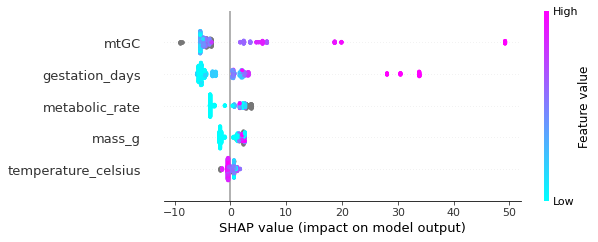

In [127]:
#shap.summary_plot('mass_g', shap_values, df)
shap.summary_plot(shap_values, df, feature_names=shap_feature_names, sort=True, plot_type='dot', max_display=30, show=False)


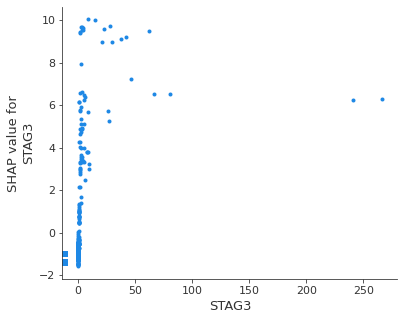

In [101]:
shap.dependence_plot("STAG3", shap_values, df, interaction_index=None, feature_names=shap_feature_names, display_features=X_display)

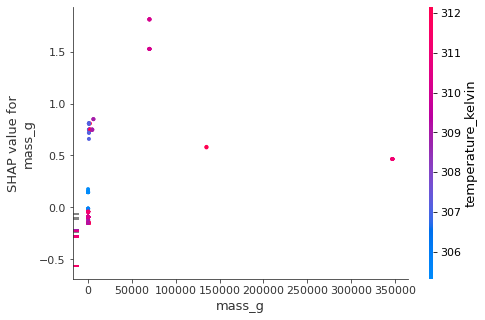

In [644]:
shap.dependence_plot("mass_g", shap_values, df, interaction_index='temperature_kelvin', feature_names=shap_feature_names, display_features=X_display)


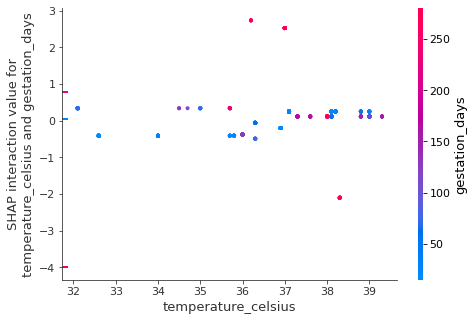

In [75]:
shap.dependence_plot(
    ("temperature_celsius", "gestation_days"),
    interaction_values, df,
    display_features=df
)

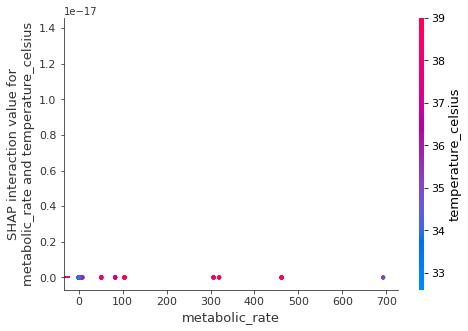

In [80]:
shap.dependence_plot(
    ("metabolic_rate", "temperature_celsius"),
    interaction_values, df,
    display_features=df,
    feature_names=shap_feature_names
)

In [685]:
pprint(tmp2)

array([[  0.        ,  37.43459881, 249.30134534,  30.25208247,
         77.25582702,  46.78504629,  12.38447138,  34.08195936,
          7.48038372,  19.90076071, 114.35703266,  46.56489649,
         46.77540103,  26.80170184,  29.80138187,   0.        ,
          0.        ,   0.        ,  12.90350101,   0.        ,
         29.01795311,  15.08293097,  14.3457728 ,   1.88799884,
         17.34494482],
       [ 37.43459881,   0.        ,   0.        ,   0.        ,
         46.81452679,   0.        ,  96.00287688,   0.        ,
          0.        ,  39.69269844,   0.        ,  22.70983839,
         27.79895313,   0.        ,  16.49718403,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   1.87509904,   0.        ,   0.        ,
          0.        ],
       [249.30134534,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.    

In [140]:
# This is a small check of code from the skimage package. It is reproduced
# here because all we need is a couple color conversion routines, and adding
# all of skimage as dependecy is really heavy.



# Copyright (C) 2019, the scikit-image team
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are
# met:

#  1. Redistributions of source code must retain the above copyright
#     notice, this list of conditions and the following disclaimer.
#  2. Redistributions in binary form must reproduce the above copyright
#     notice, this list of conditions and the following disclaimer in
#     the documentation and/or other materials provided with the
#     distribution.
#  3. Neither the name of skimage nor the names of its contributors may be
#     used to endorse or promote products derived from this software without
#     specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE AUTHOR ``AS IS'' AND ANY EXPRESS OR
# IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
# WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT,
# INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
# (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION)
# HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT,
# STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING
# IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

# skimage/_shared/version_requirements.py:_check_version

#     Copyright (c) 2013 The IPython Development Team
#     All rights reserved.

#     Redistribution and use in source and binary forms, with or without
#     modification, are permitted provided that the following conditions are met:

#     * Redistributions of source code must retain the above copyright notice, this
#       list of conditions and the following disclaimer.

#     * Redistributions in binary form must reproduce the above copyright notice,
#       this list of conditions and the following disclaimer in the documentation
#       and/or other materials provided with the distribution.

#     * Neither the name of the copyright holder nor the names of its
#       contributors may be used to endorse or promote products derived from
#       this software without specific prior written permission.

#     THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
#     AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
#     IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
#     DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
#     FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
#     DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
#     SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
#     CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
#     OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
#     OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# skimage/_shared/version_requirements.py:is_installed:

#     Original Copyright (C) 2009-2011 Pierre Raybaut

#     Permission is hereby granted, free of charge, to any person obtaining
#     a copy of this software and associated documentation files (the
#     "Software"), to deal in the Software without restriction, including
#     without limitation the rights to use, copy, modify, merge, publish,
#     distribute, sublicense, and/or sell copies of the Software, and to
#     permit persons to whom the Software is furnished to do so, subject to
#     the following conditions:

#     The above copyright notice and this permission notice shall be
#     included in all copies or substantial portions of the Software.

#     THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
#     EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF
#     MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
#     NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
#     LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
#     OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION
#     WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# skimage/external/tifffile:

#     Copyright (c) 2008-2014, Christoph Gohlke
#     Copyright (c) 2008-2014, The Regents of the University of California
#     Produced at the Laboratory for Fluorescence Dynamics
#     All rights reserved.

#     Redistribution and use in source and binary forms, with or without
#     modification, are permitted provided that the following conditions are met:

#     * Redistributions of source code must retain the above copyright notice,
#       this list of conditions and the following disclaimer.

#     * Redistributions in binary form must reproduce the above copyright notice,
#       this list of conditions and the following disclaimer in the documentation
#       and/or other materials provided with the distribution.

#     * Neither the name of the copyright holder nor the names of its
#       contributors may be used to endorse or promote products derived from
#       this software without specific prior written permission.

#     THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
#     AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
#     IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
#     ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
#     LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
#     CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
#     SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
#     INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
#     CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
#     ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
#     POSSIBILITY OF SUCH DAMAGE.



import numpy as np
from scipy import linalg
from warnings import warn

def lab2xyz(lab, illuminant="D65", observer="2"):
    """CIE-LAB to XYZcolor space conversion.
    Parameters
    ----------
    lab : array_like
        The image in lab format, in a 3-D array of shape ``(.., .., 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in XYZ format, in a 3-D array of shape ``(.., .., 3)``.
    Raises
    ------
    ValueError
        If `lab` is not a 3-D array of shape ``(.., .., 3)``.
    ValueError
        If either the illuminant or the observer angle are not supported or
        unknown.
    UserWarning
        If any of the pixels are invalid (Z < 0).
    Notes
    -----
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values x_ref
    = 95.047, y_ref = 100., z_ref = 108.883. See function 'get_xyz_coords' for
    a list of supported illuminants.
    References
    ----------
    .. [1] http://www.easyrgb.com/index.php?X=MATH&H=07#text7
    .. [2] https://en.wikipedia.org/wiki/Lab_color_space
    """

    arr = _prepare_colorarray(lab).copy()

    L, a, b = arr[:, :, 0], arr[:, :, 1], arr[:, :, 2]
    y = (L + 16.) / 116.
    x = (a / 500.) + y
    z = y - (b / 200.)

    if np.any(z < 0):
        invalid = np.nonzero(z < 0)
        warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size,
             stacklevel=2)
        z[invalid] = 0

    out = np.dstack([x, y, z])

    mask = out > 0.2068966
    out[mask] = np.power(out[mask], 3.)
    out[~mask] = (out[~mask] - 16.0 / 116.) / 7.787

    # rescale to the reference white (illuminant)
    xyz_ref_white = get_xyz_coords(illuminant, observer)
    out *= xyz_ref_white
    return out

def xyz2lab(xyz, illuminant="D65", observer="2"):
    """XYZ to CIE-LAB color space conversion.
    Parameters
    ----------
    xyz : array_like
        The image in XYZ format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in CIE-LAB format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    Raises
    ------
    ValueError
        If `xyz` is not a 3-D array of shape ``(.., ..,[ ..,] 3)``.
    ValueError
        If either the illuminant or the observer angle is unsupported or
        unknown.
    Notes
    -----
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values
    x_ref=95.047, y_ref=100., z_ref=108.883. See function `get_xyz_coords` for
    a list of supported illuminants.
    References
    ----------
    .. [1] http://www.easyrgb.com/index.php?X=MATH&H=07#text7
    .. [2] https://en.wikipedia.org/wiki/Lab_color_space
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2xyz, xyz2lab
    >>> img = data.astronaut()
    >>> img_xyz = rgb2xyz(img)
    >>> img_lab = xyz2lab(img_xyz)
    """
    arr = _prepare_colorarray(xyz)

    xyz_ref_white = get_xyz_coords(illuminant, observer)

    # scale by CIE XYZ tristimulus values of the reference white point
    arr = arr / xyz_ref_white

    # Nonlinear distortion and linear transformation
    mask = arr > 0.008856
    arr[mask] = np.cbrt(arr[mask])
    arr[~mask] = 7.787 * arr[~mask] + 16. / 116.

    x, y, z = arr[..., 0], arr[..., 1], arr[..., 2]

    # Vector scaling
    L = (116. * y) - 16.
    a = 500.0 * (x - y)
    b = 200.0 * (y - z)

    return np.concatenate([x[..., np.newaxis] for x in [L, a, b]], axis=-1)

def lab2rgb(lab, illuminant="D65", observer="2"):
    """Lab to RGB color space conversion.
    Parameters
    ----------
    lab : array_like
        The image in Lab format, in a 3-D array of shape ``(.., .., 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    Raises
    ------
    ValueError
        If `lab` is not a 3-D array of shape ``(.., .., 3)``.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Standard_illuminant
    Notes
    -----
    This function uses lab2xyz and xyz2rgb.
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values
    x_ref=95.047, y_ref=100., z_ref=108.883. See function `get_xyz_coords` for
    a list of supported illuminants.
    """
    return xyz2rgb(lab2xyz(lab, illuminant, observer))


def rgb2lab(rgb, illuminant="D65", observer="2"):
    """RGB to lab color space conversion.
    Parameters
    ----------
    rgb : array_like
        The image in RGB format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    out : ndarray
        The image in Lab format, in a 3- or 4-D array of shape
        ``(.., ..,[ ..,] 3)``.
    Raises
    ------
    ValueError
        If `rgb` is not a 3- or 4-D array of shape ``(.., ..,[ ..,] 3)``.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Standard_illuminant
    Notes
    -----
    This function uses rgb2xyz and xyz2lab.
    By default Observer= 2A, Illuminant= D65. CIE XYZ tristimulus values
    x_ref=95.047, y_ref=100., z_ref=108.883. See function `get_xyz_coords` for
    a list of supported illuminants.
    """
    return xyz2lab(rgb2xyz(rgb), illuminant, observer)

def lch2lab(lch):
    """CIE-LCH to CIE-LAB color space conversion.
    LCH is the cylindrical representation of the LAB (Cartesian) colorspace
    Parameters
    ----------
    lch : array_like
        The N-D image in CIE-LCH format. The last (``N+1``-th) dimension must
        have at least 3 elements, corresponding to the ``L``, ``a``, and ``b``
        color channels.  Subsequent elements are copied.
    Returns
    -------
    out : ndarray
        The image in LAB format, with same shape as input `lch`.
    Raises
    ------
    ValueError
        If `lch` does not have at least 3 color channels (i.e. l, c, h).
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2lab, lch2lab
    >>> img = data.astronaut()
    >>> img_lab = rgb2lab(img)
    >>> img_lch = lab2lch(img_lab)
    >>> img_lab2 = lch2lab(img_lch)
    """
    lch = _prepare_lab_array(lch)

    c, h = lch[..., 1], lch[..., 2]
    lch[..., 1], lch[..., 2] = c * np.cos(h), c * np.sin(h)
    return lch

def _prepare_lab_array(arr):
    """Ensure input for lab2lch, lch2lab are well-posed.
    Arrays must be in floating point and have at least 3 elements in
    last dimension.  Return a new array.
    """
    arr = np.asarray(arr)
    shape = arr.shape
    if shape[-1] < 3:
        raise ValueError('Input array has less than 3 color channels')
    return img_as_float(arr, force_copy=True)

def get_xyz_coords(illuminant, observer):
    """Get the XYZ coordinates of the given illuminant and observer [1]_.
    Parameters
    ----------
    illuminant : {"A", "D50", "D55", "D65", "D75", "E"}, optional
        The name of the illuminant (the function is NOT case sensitive).
    observer : {"2", "10"}, optional
        The aperture angle of the observer.
    Returns
    -------
    (x, y, z) : tuple
        A tuple with 3 elements containing the XYZ coordinates of the given
        illuminant.
    Raises
    ------
    ValueError
        If either the illuminant or the observer angle are not supported or
        unknown.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Standard_illuminant
    """
    illuminant = illuminant.upper()
    try:
        return illuminants[illuminant][observer]
    except KeyError:
        raise ValueError("Unknown illuminant/observer combination\
        (\'{0}\', \'{1}\')".format(illuminant, observer))

def _prepare_colorarray(arr):
    """Check the shape of the array and convert it to
    floating point representation.
    """
    arr = np.asanyarray(arr)

    if arr.ndim not in [3, 4] or arr.shape[-1] != 3:
        msg = ("the input array must be have a shape == (.., ..,[ ..,] 3)), " +
               "got (" + (", ".join(map(str, arr.shape))) + ")")
        raise ValueError(msg)

    return img_as_float(arr)

def xyz2rgb(xyz):
    """XYZ to RGB color space conversion.
    Parameters
    ----------
    xyz : array_like
        The image in XYZ format, in a 3-D array of shape ``(.., .., 3)``.
    Returns
    -------
    out : ndarray
        The image in RGB format, in a 3-D array of shape ``(.., .., 3)``.
    Raises
    ------
    ValueError
        If `xyz` is not a 3-D array of shape ``(.., .., 3)``.
    Notes
    -----
    The CIE XYZ color space is derived from the CIE RGB color space. Note
    however that this function converts to sRGB.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/CIE_1931_color_space
    Examples
    --------
    >>> from skimage import data
    >>> from skimage.color import rgb2xyz, xyz2rgb
    >>> img = data.astronaut()
    >>> img_xyz = rgb2xyz(img)
    >>> img_rgb = xyz2rgb(img_xyz)
    """
    # Follow the algorithm from http://www.easyrgb.com/index.php
    # except we don't multiply/divide by 100 in the conversion
    arr = _convert(rgb_from_xyz, xyz)
    mask = arr > 0.0031308
    arr[mask] = 1.055 * np.power(arr[mask], 1 / 2.4) - 0.055
    arr[~mask] *= 12.92
    np.clip(arr, 0, 1, out=arr)
    return arr

def _convert(matrix, arr):
    """Do the color space conversion.
    Parameters
    ----------
    matrix : array_like
        The 3x3 matrix to use.
    arr : array_like
        The input array.
    Returns
    -------
    out : ndarray, dtype=float
        The converted array.
    """
    arr = _prepare_colorarray(arr)

    return arr @ matrix.T.copy()

# ---------------------------------------------------------------
# Primaries for the coordinate systems
# ---------------------------------------------------------------
cie_primaries = np.array([700, 546.1, 435.8])
sb_primaries = np.array([1. / 155, 1. / 190, 1. / 225]) * 1e5

# ---------------------------------------------------------------
# Matrices that define conversion between different color spaces
# ---------------------------------------------------------------

# From sRGB specification
xyz_from_rgb = np.array([[0.412453, 0.357580, 0.180423],
                         [0.212671, 0.715160, 0.072169],
                         [0.019334, 0.119193, 0.950227]])

rgb_from_xyz = linalg.inv(xyz_from_rgb)

# From https://en.wikipedia.org/wiki/CIE_1931_color_space
# Note: Travis's code did not have the divide by 0.17697
xyz_from_rgbcie = np.array([[0.49, 0.31, 0.20],
                            [0.17697, 0.81240, 0.01063],
                            [0.00, 0.01, 0.99]]) / 0.17697

rgbcie_from_xyz = linalg.inv(xyz_from_rgbcie)

# construct matrices to and from rgb:
rgbcie_from_rgb = rgbcie_from_xyz @ xyz_from_rgb
rgb_from_rgbcie = rgb_from_xyz @ xyz_from_rgbcie


gray_from_rgb = np.array([[0.2125, 0.7154, 0.0721],
                          [0, 0, 0],
                          [0, 0, 0]])

yuv_from_rgb = np.array([[ 0.299     ,  0.587     ,  0.114      ],
                         [-0.14714119, -0.28886916,  0.43601035 ],
                         [ 0.61497538, -0.51496512, -0.10001026 ]])

rgb_from_yuv = linalg.inv(yuv_from_rgb)

yiq_from_rgb = np.array([[0.299     ,  0.587     ,  0.114     ],
                         [0.59590059, -0.27455667, -0.32134392],
                         [0.21153661, -0.52273617,  0.31119955]])

rgb_from_yiq = linalg.inv(yiq_from_rgb)

ypbpr_from_rgb = np.array([[ 0.299   , 0.587   , 0.114   ],
                           [-0.168736,-0.331264, 0.5     ],
                           [ 0.5     ,-0.418688,-0.081312]])

rgb_from_ypbpr = linalg.inv(ypbpr_from_rgb)

ycbcr_from_rgb = np.array([[    65.481,   128.553,    24.966],
                           [   -37.797,   -74.203,   112.0  ],
                           [   112.0  ,   -93.786,   -18.214]])

rgb_from_ycbcr = linalg.inv(ycbcr_from_rgb)

ydbdr_from_rgb = np.array([[    0.299,   0.587,    0.114],
                           [   -0.45 ,  -0.883,    1.333],
                           [   -1.333,   1.116,    0.217]])

rgb_from_ydbdr = linalg.inv(ydbdr_from_rgb)


# CIE LAB constants for Observer=2A, Illuminant=D65
# NOTE: this is actually the XYZ values for the illuminant above.
lab_ref_white = np.array([0.95047, 1., 1.08883])


# XYZ coordinates of the illuminants, scaled to [0, 1]. For each illuminant I
# we have:
#
#   illuminant[I][0] corresponds to the XYZ coordinates for the 2 degree
#   field of view.
#
#   illuminant[I][1] corresponds to the XYZ coordinates for the 10 degree
#   field of view.
#
# The XYZ coordinates are calculated from [1], using the formula:
#
#   X = x * ( Y / y )
#   Y = Y
#   Z = ( 1 - x - y ) * ( Y / y )
#
# where Y = 1. The only exception is the illuminant "D65" with aperture angle
# 2, whose coordinates are copied from 'lab_ref_white' for
# backward-compatibility reasons.
#
#     References
#    ----------
#    .. [1] https://en.wikipedia.org/wiki/Standard_illuminant

illuminants = \
    {"A": {'2': (1.098466069456375, 1, 0.3558228003436005),
           '10': (1.111420406956693, 1, 0.3519978321919493)},
     "D50": {'2': (0.9642119944211994, 1, 0.8251882845188288),
             '10': (0.9672062750333777, 1, 0.8142801513128616)},
     "D55": {'2': (0.956797052643698, 1, 0.9214805860173273),
             '10': (0.9579665682254781, 1, 0.9092525159847462)},
     "D65": {'2': (0.95047, 1., 1.08883),   # This was: `lab_ref_white`
             '10': (0.94809667673716, 1, 1.0730513595166162)},
     "D75": {'2': (0.9497220898840717, 1, 1.226393520724154),
             '10': (0.9441713925645873, 1, 1.2064272211720228)},
     "E": {'2': (1.0, 1.0, 1.0),
           '10': (1.0, 1.0, 1.0)}}




__all__ = ['img_as_float32', 'img_as_float64', 'img_as_float',
           'img_as_int', 'img_as_uint', 'img_as_ubyte',
           'img_as_bool', 'dtype_limits']

# For integers Numpy uses `_integer_types` basis internally, and builds a leaky
# `np.XintYY` abstraction on top of it. This leads to situations when, for
# example, there are two np.Xint64 dtypes with the same attributes but
# different object references. In order to avoid any potential issues,
# we use the basis dtypes here. For more information, see:
# - https://github.com/scikit-image/scikit-image/issues/3043
# For convenience, for these dtypes we indicate also the possible bit depths
# (some of them are platform specific). For the details, see:
# http://www.unix.org/whitepapers/64bit.html
_integer_types = (np.byte, np.ubyte,          # 8 bits
                  np.short, np.ushort,        # 16 bits
                  np.intc, np.uintc,          # 16 or 32 or 64 bits
                  np.int_, np.uint,           # 32 or 64 bits
                  np.longlong, np.ulonglong)  # 64 bits
_integer_ranges = {t: (np.iinfo(t).min, np.iinfo(t).max)
                   for t in _integer_types}
dtype_range = {np.bool_: (False, True),
               np.bool8: (False, True),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dtype_range.update(_integer_ranges)

_supported_types = list(dtype_range.keys())


def dtype_limits(image, clip_negative=False):
    """Return intensity limits, i.e. (min, max) tuple, of the image's dtype.
    Parameters
    ----------
    image : ndarray
        Input image.
    clip_negative : bool, optional
        If True, clip the negative range (i.e. return 0 for min intensity)
        even if the image dtype allows negative values.
    Returns
    -------
    imin, imax : tuple
        Lower and upper intensity limits.
    """
    imin, imax = dtype_range[image.dtype.type]
    if clip_negative:
        imin = 0
    return imin, imax


def _dtype_itemsize(itemsize, *dtypes):
    """Return first of `dtypes` with itemsize greater than `itemsize`
    Parameters
    ----------
    itemsize: int
        The data type object element size.
    Other Parameters
    ----------------
    *dtypes:
        Any Object accepted by `np.dtype` to be converted to a data
        type object
    Returns
    -------
    dtype: data type object
        First of `dtypes` with itemsize greater than `itemsize`.
    """
    return next(dt for dt in dtypes if np.dtype(dt).itemsize >= itemsize)


def _dtype_bits(kind, bits, itemsize=1):
    """Return dtype of `kind` that can store a `bits` wide unsigned int
    Parameters:
    kind: str
        Data type kind.
    bits: int
        Desired number of bits.
    itemsize: int
        The data type object element size.
    Returns
    -------
    dtype: data type object
        Data type of `kind` that can store a `bits` wide unsigned int
    """

    s = next(i for i in (itemsize, ) + (2, 4, 8) if
             bits < (i * 8) or (bits == (i * 8) and kind == 'u'))

    return np.dtype(kind + str(s))


def _scale(a, n, m, copy=True):
    """Scale an array of unsigned/positive integers from `n` to `m` bits.
    Numbers can be represented exactly only if `m` is a multiple of `n`.
    Parameters
    ----------
    a : ndarray
        Input image array.
    n : int
        Number of bits currently used to encode the values in `a`.
    m : int
        Desired number of bits to encode the values in `out`.
    copy : bool, optional
        If True, allocates and returns new array. Otherwise, modifies
        `a` in place.
    Returns
    -------
    out : array
        Output image array. Has the same kind as `a`.
    """
    kind = a.dtype.kind
    if n > m and a.max() < 2 ** m:
        mnew = int(np.ceil(m / 2) * 2)
        if mnew > m:
            dtype = "int{}".format(mnew)
        else:
            dtype = "uint{}".format(mnew)
        n = int(np.ceil(n / 2) * 2)
        warn("Downcasting {} to {} without scaling because max "
             "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype),
             stacklevel=3)
        return a.astype(_dtype_bits(kind, m))
    elif n == m:
        return a.copy() if copy else a
    elif n > m:
        # downscale with precision loss
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, m))
            np.floor_divide(a, 2**(n - m), out=b, dtype=a.dtype,
                            casting='unsafe')
            return b
        else:
            a //= 2**(n - m)
            return a
    elif m % n == 0:
        # exact upscale to a multiple of `n` bits
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, m))
            np.multiply(a, (2**m - 1) // (2**n - 1), out=b, dtype=b.dtype)
            return b
        else:
            a = a.astype(_dtype_bits(kind, m, a.dtype.itemsize), copy=False)
            a *= (2**m - 1) // (2**n - 1)
            return a
    else:
        # upscale to a multiple of `n` bits,
        # then downscale with precision loss
        o = (m // n + 1) * n
        if copy:
            b = np.empty(a.shape, _dtype_bits(kind, o))
            np.multiply(a, (2**o - 1) // (2**n - 1), out=b, dtype=b.dtype)
            b //= 2**(o - m)
            return b
        else:
            a = a.astype(_dtype_bits(kind, o, a.dtype.itemsize), copy=False)
            a *= (2**o - 1) // (2**n - 1)
            a //= 2**(o - m)
            return a


def convert(image, dtype, force_copy=False, uniform=False):
    """
    Convert an image to the requested data-type.
    Warnings are issued in case of precision loss, or when negative values
    are clipped during conversion to unsigned integer types (sign loss).
    Floating point values are expected to be normalized and will be clipped
    to the range [0.0, 1.0] or [-1.0, 1.0] when converting to unsigned or
    signed integers respectively.
    Numbers are not shifted to the negative side when converting from
    unsigned to signed integer types. Negative values will be clipped when
    converting to unsigned integers.
    Parameters
    ----------
    image : ndarray
        Input image.
    dtype : dtype
        Target data-type.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    uniform : bool, optional
        Uniformly quantize the floating point range to the integer range.
        By default (uniform=False) floating point values are scaled and
        rounded to the nearest integers, which minimizes back and forth
        conversion errors.
    .. versionchanged :: 0.15
        ``convert`` no longer warns about possible precision or sign
        information loss. See discussions on these warnings at:
        https://github.com/scikit-image/scikit-image/issues/2602
        https://github.com/scikit-image/scikit-image/issues/543#issuecomment-208202228
        https://github.com/scikit-image/scikit-image/pull/3575
    References
    ----------
    .. [1] DirectX data conversion rules.
           https://msdn.microsoft.com/en-us/library/windows/desktop/dd607323%28v=vs.85%29.aspx
    .. [2] Data Conversions. In "OpenGL ES 2.0 Specification v2.0.25",
           pp 7-8. Khronos Group, 2010.
    .. [3] Proper treatment of pixels as integers. A.W. Paeth.
           In "Graphics Gems I", pp 249-256. Morgan Kaufmann, 1990.
    .. [4] Dirty Pixels. J. Blinn. In "Jim Blinn's corner: Dirty Pixels",
           pp 47-57. Morgan Kaufmann, 1998.
    """
    image = np.asarray(image)
    dtypeobj_in = image.dtype
    dtypeobj_out = np.dtype(dtype)
    dtype_in = dtypeobj_in.type
    dtype_out = dtypeobj_out.type
    kind_in = dtypeobj_in.kind
    kind_out = dtypeobj_out.kind
    itemsize_in = dtypeobj_in.itemsize
    itemsize_out = dtypeobj_out.itemsize

    # Below, we do an `issubdtype` check.  Its purpose is to find out
    # whether we can get away without doing any image conversion.  This happens
    # when:
    #
    # - the output and input dtypes are the same or
    # - when the output is specified as a type, and the input dtype
    #   is a subclass of that type (e.g. `np.floating` will allow
    #   `float32` and `float64` arrays through)

    if np.issubdtype(dtype_in, np.obj2sctype(dtype)):
        if force_copy:
            image = image.copy()
        return image

    if not (dtype_in in _supported_types and dtype_out in _supported_types):
        raise ValueError("Can not convert from {} to {}."
                         .format(dtypeobj_in, dtypeobj_out))

    if kind_in in 'ui':
        imin_in = np.iinfo(dtype_in).min
        imax_in = np.iinfo(dtype_in).max
    if kind_out in 'ui':
        imin_out = np.iinfo(dtype_out).min
        imax_out = np.iinfo(dtype_out).max

    # any -> binary
    if kind_out == 'b':
        return image > dtype_in(dtype_range[dtype_in][1] / 2)

    # binary -> any
    if kind_in == 'b':
        result = image.astype(dtype_out)
        if kind_out != 'f':
            result *= dtype_out(dtype_range[dtype_out][1])
        return result

    # float -> any
    if kind_in == 'f':
        if kind_out == 'f':
            # float -> float
            return image.astype(dtype_out)

        if np.min(image) < -1.0 or np.max(image) > 1.0:
            raise ValueError("Images of type float must be between -1 and 1.")
        # floating point -> integer
        # use float type that can represent output integer type
        computation_type = _dtype_itemsize(itemsize_out, dtype_in,
                                           np.float32, np.float64)

        if not uniform:
            if kind_out == 'u':
                image_out = np.multiply(image, imax_out,
                                        dtype=computation_type)
            else:
                image_out = np.multiply(image, (imax_out - imin_out) / 2,
                                        dtype=computation_type)
                image_out -= 1.0 / 2.
            np.rint(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        elif kind_out == 'u':
            image_out = np.multiply(image, imax_out + 1,
                                    dtype=computation_type)
            np.clip(image_out, 0, imax_out, out=image_out)
        else:
            image_out = np.multiply(image, (imax_out - imin_out + 1.0) / 2.0,
                                    dtype=computation_type)
            np.floor(image_out, out=image_out)
            np.clip(image_out, imin_out, imax_out, out=image_out)
        return image_out.astype(dtype_out)

    # signed/unsigned int -> float
    if kind_out == 'f':
        # use float type that can exactly represent input integers
        computation_type = _dtype_itemsize(itemsize_in, dtype_out,
                                           np.float32, np.float64)

        if kind_in == 'u':
            # using np.divide or np.multiply doesn't copy the data
            # until the computation time
            image = np.multiply(image, 1. / imax_in,
                                dtype=computation_type)
            # DirectX uses this conversion also for signed ints
            # if imin_in:
            #     np.maximum(image, -1.0, out=image)
        else:
            image = np.add(image, 0.5, dtype=computation_type)
            image *= 2 / (imax_in - imin_in)

        return np.asarray(image, dtype_out)

    # unsigned int -> signed/unsigned int
    if kind_in == 'u':
        if kind_out == 'i':
            # unsigned int -> signed int
            image = _scale(image, 8 * itemsize_in, 8 * itemsize_out - 1)
            return image.view(dtype_out)
        else:
            # unsigned int -> unsigned int
            return _scale(image, 8 * itemsize_in, 8 * itemsize_out)

    # signed int -> unsigned int
    if kind_out == 'u':
        image = _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out)
        result = np.empty(image.shape, dtype_out)
        np.maximum(image, 0, out=result, dtype=image.dtype, casting='unsafe')
        return result

    # signed int -> signed int
    if itemsize_in > itemsize_out:
        return _scale(image, 8 * itemsize_in - 1, 8 * itemsize_out - 1)

    image = image.astype(_dtype_bits('i', itemsize_out * 8))
    image -= imin_in
    image = _scale(image, 8 * itemsize_in, 8 * itemsize_out, copy=False)
    image += imin_out
    return image.astype(dtype_out)


def img_as_float32(image, force_copy=False):
    """Convert an image to single-precision (32-bit) floating point format.
    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    Returns
    -------
    out : ndarray of float32
        Output image.
    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].
    """
    return convert(image, np.float32, force_copy)


def img_as_float64(image, force_copy=False):
    """Convert an image to double-precision (64-bit) floating point format.
    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    Returns
    -------
    out : ndarray of float64
        Output image.
    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].
    """
    return convert(image, np.float64, force_copy)


def img_as_float(image, force_copy=False):
    """Convert an image to floating point format.
    This function is similar to `img_as_float64`, but will not convert
    lower-precision floating point arrays to `float64`.
    Parameters
    ----------
    image : ndarray
        Input image.
    force_copy : bool, optional
        Force a copy of the data, irrespective of its current dtype.
    Returns
    -------
    out : ndarray of float
        Output image.
    Notes
    -----
    The range of a floating point image is [0.0, 1.0] or [-1.0, 1.0] when
    converting from unsigned or signed datatypes, respectively.
    If the input image has a float type, intensity values are not modified
    and can be outside the ranges [0.0, 1.0] or [-1.0, 1.0].
    """
    return convert(image, np.floating, force_copy)

In [141]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]

# define our colors using Lch
# note that we intentionally vary the lightness during interpolation so as to better
# enable the eye to see patterns (since patterns are most easily recognized through
# lightness variability)
blue_lch = [54., 70., 4.6588]
l_mid = 40.
red_lch = [54., 90., 0.35470565 + 2* np.pi]
gray_lch = [55., 0., 0.]
blue_rgb = lch2rgb(blue_lch)
red_rgb = lch2rgb(red_lch)
gray_rgb = lch2rgb(gray_lch)

# define a perceptually uniform color scale using the Lch color space
reds = []
greens = []
blues = []
alphas = []
nsteps = 100
l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps//2)) + list(np.linspace(l_mid, red_lch[0], nsteps//2))
c_vals = np.linspace(blue_lch[1], red_lch[1], nsteps)
h_vals = np.linspace(blue_lch[2], red_lch[2], nsteps)
for pos,l,c,h in zip(np.linspace(0, 1, nsteps), l_vals, c_vals, h_vals):
    lch = [l, c, h]
    rgb = lch2rgb(lch)
    reds.append((pos, rgb[0], rgb[0]))
    greens.append((pos, rgb[1], rgb[1]))
    blues.append((pos, rgb[2], rgb[2]))
    alphas.append((pos, 1.0, 1.0))

red_blue = LinearSegmentedColormap('red_blue', {
    "red": reds,
    "green": greens,
    "blue": blues,
    "alpha": alphas
})
red_blue.set_bad(gray_rgb, 1.0)
red_blue.set_over(gray_rgb, 1.0)
red_blue.set_under(gray_rgb, 1.0) # "under" is incorrectly used instead of "bad" in the scatter plot

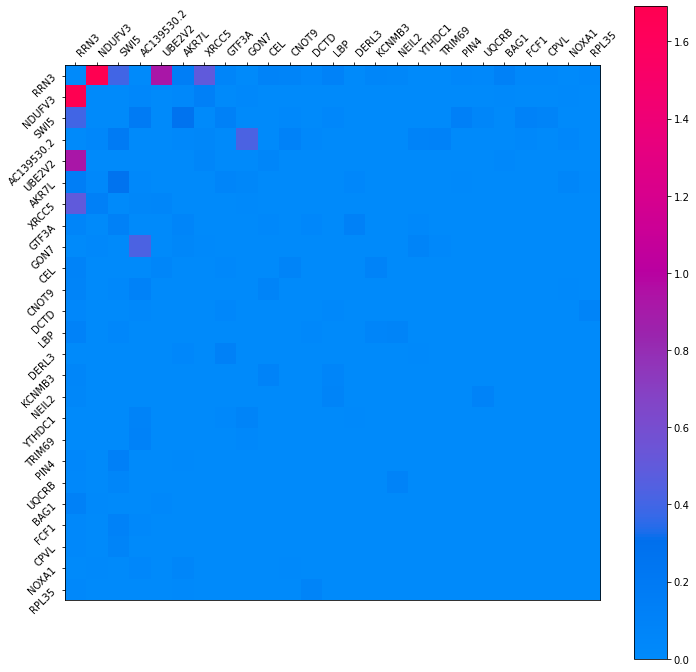

In [143]:
import matplotlib.pylab as pl
import numpy as np

tmp = np.abs(interaction_values).mean(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:25]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2, cmap=red_blue)
pl.colorbar()

pl.yticks(range(tmp2.shape[0]), np.array(shap_feature_names)[inds], rotation=45, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), np.array(shap_feature_names)[inds], rotation=45, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

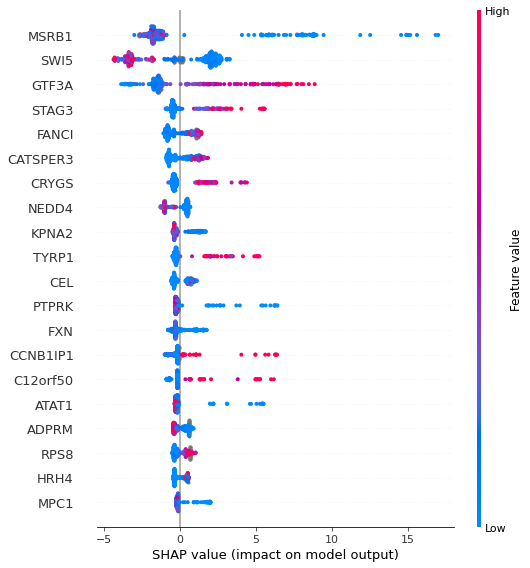

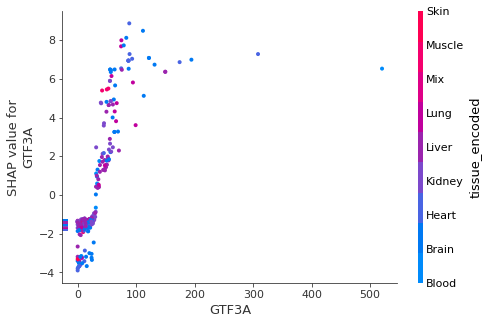

In [333]:
def plot_shap_values(shap_values, X):
    shap_feature_names = []
    X_display = X.copy()
    X_display['tissue_encoded'] = le.inverse_transform(X_display['tissue_encoded'].values)
    for col in X.columns:
        if 'ENSG' in col:
            shap_feature_names.append(ensemble_data.gene_name_of_gene_id(col))
        else:
            shap_feature_names.append(col)
            
    shap.summary_plot(shap_values, X, feature_names=shap_feature_names)
    shap.dependence_plot("GTF3A", shap_values, X, interaction_index='tissue_encoded', feature_names=shap_feature_names, display_features=X_display)

plot_shap_values(shap_values, feature_df)